In [18]:
!pip install ffmpeg-python
!pip install sounddevice

import matplotlib.pyplot as plt
from IPython.display import HTML, Audio
from base64 import b64decode
import numpy as np
import statistics

import json
import time

import struct
import io
import ffmpeg
import sounddevice as sd

from scipy.io import wavfile
from scipy.io.wavfile import read as wav_read
from scipy import signal, stats
from scipy.signal import chirp, detrend, detrend, butter, filtfilt, find_peaks, savgol_filter
from queue import Queue
import threading

In [19]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutoff / nyq
    b, a = signal.butter(order, normalCutoff, btype='low')
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def highpass(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='high')
    return filtfilt(b, a, data)

# HR range (0.67–3.33 Hz = 40–200 BPM)
def bandpass(data, lowcut, highcut, fs, order=10):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [20]:
def play_and_record_chirp(freq_low, freq_high, sample_rate, chirp_duration, total_duration, get_hr_func):
    chirp_t       = np.linspace(0, chirp_duration, int(sample_rate * chirp_duration), endpoint=False)
    chirp_x       = chirp(chirp_t, f0=freq_low, f1=freq_high, t1=chirp_duration, method='linear').astype(np.float32)
    chirps_needed = int(total_duration / chirp_duration)
    tx_full       = np.tile(chirp_x, chirps_needed)

    chirp_len     = len(tx_full)
    tx_idx        = [0]

    rx_queue      = Queue()
    rx_recorded   = []

    CHUNK_SECONDS = 5
    CHUNK_SAMPLES = sample_rate * CHUNK_SECONDS
    buffer        = []

    # Start time tracking
    start_time    = time.time()
    hr_delay      = 15  # Wait 15 seconds before get_hr
    last_hr_check = time.time()

    # Accumulate and send chunks
    def callback(indata, outdata, frames, stream_time, status):

        # Chirp playback
        start = tx_idx[0]
        end   = start + frames
        if end > chirp_len:
            part1 = tx_full[start:]
            part2 = tx_full[:end - chirp_len]
            out_chunk = np.concatenate((part1, part2))
            tx_idx[0] = end - chirp_len
        else:
            out_chunk = tx_full[start:end]
            tx_idx[0] = end

        outdata[:] = out_chunk.reshape(-1, 1)

        # Accumulate input
        buffer.extend(indata.copy().flatten())

        if len(buffer) >= CHUNK_SAMPLES:
            try:
                rx_chunk = np.array(buffer[:CHUNK_SAMPLES])
                rx_queue.put_nowait(rx_chunk)
                del buffer[:CHUNK_SAMPLES]
            except:
                print("Queue full, dropping chunk")

    # Background processing thread
    def worker():
        last_hr_time = time.time()
        total_elapsed = lambda: time.time() - start_time

        while True:
            try:
                chunk = rx_queue.get(timeout=0.1)
                rx_recorded.append(chunk)
            except:
                continue

            # Don't process until 15s have passed
            if total_elapsed() < hr_delay:
                continue

            # Only process every 5 seconds
            if time.time() - last_hr_time < CHUNK_SECONDS:
                continue

            last_hr_time = time.time()
            rx_so_far = np.concatenate(rx_recorded)
            tx_match = tx_full[:len(rx_so_far)]
            try:
                bpm_from_peaks, bpm_from_fft = get_hr(tx_match, rx_so_far)
                if bpm_from_peaks:
                    print(f"Heart Rate (from peak intervals): {bpm_from_peaks:.2f} BPM")
                else:
                    print("Not enough peaks for interval-based heart rate.")
                print(f"Heart Rate (from FFT): {bpm_from_fft:.2f} BPM")
            except Exception as e:
                print("Error in get_hr:", e)

    # Start worker
    processing_thread = threading.Thread(target=worker, daemon=True)
    processing_thread.start()

    # Start audio stream
    with sd.Stream(samplerate=sample_rate,
                   blocksize=2048,
                   channels=1,
                   dtype='float32',
                   latency='high',
                   callback=callback):
        print("Streaming... Press Ctrl+C to stop.")
        try:
            sd.sleep(int(total_duration * 1000))
        except KeyboardInterrupt:
            print("Stopped by user.")

    # Get remaining data
    rx_full = np.concatenate(list(rx_queue.queue) + [np.array(buffer)])
    return tx_full, rx_full

In [21]:
sample_rate = 48000
freq_low = 1000        # start of chirp (Hz)
freq_high = 23000       # end of chirp (Hz)
chirp_length = 0.1      # duration of each chirp in seconds
total_duration = 60     # total recording time in seconds
fs = 1 / chirp_length

c = 343  # (m/s)
bandwidth = freq_high-freq_low  

range_resolution = c / (2 * bandwidth)
print(f"resolution: {range_resolution * 1000:.1f} mm")

resolution: 7.8 mm


In [22]:
def preprocess(tx, rx):
    tx_sig = tx;
    rx_sig = rx
    
    num_chirps_recorded = int(rx_sig.shape[0] // (chirp_length * sample_rate))
    
    # trim audio to a whole number of chirps recorded
    rx_sig = rx_sig[:int(num_chirps_recorded * chirp_length * sample_rate)]
    
    rx_data = np.array(np.split(rx_sig, num_chirps_recorded))
    tx_data = np.tile(tx_sig[0:int(chirp_length*sample_rate)], (num_chirps_recorded, 1))
    
    time_to_drop = 1
    segments_to_drop = int(time_to_drop/chirp_length)
    rx_data = rx_data[segments_to_drop:]
    tx_data = tx_data[segments_to_drop:]
    
    window_length = rx_data.shape[1]
    
    sample_index = 0
    
    ### save to json for testing ###
    rx_list = rx_data.tolist()
    tx_list = tx_data.tolist()
    
    with open("rx_hrbr.json", "w") as f:
        json.dump(rx_list, f)
    
    with open("tx_hrbr.json", "w") as f:
        json.dump(tx_list, f)
    ### save to json for testing ###

In [23]:
def background_subtract(all_multiplied_ffts):
    after_subtraction = []
    for i in range(30, len(all_multiplied_ffts)):
        after_subtraction.append(all_multiplied_ffts[i] - all_multiplied_ffts[i-30])
    return np.array(after_subtraction)

def moving_average(x, w):
    return np.convolve(x, np.ones(w)/w, mode='same')

def get_largest_n_mean(array, n):
    return np.mean(np.argpartition(array, -n)[-n:])

In [24]:
# --- Load Data ---
def load_from_json():
    with open("tx_hrbr.json", "r") as f_tx, open("rx_hrbr.json", "r") as f_rx:
        tx_data = json.load(f_tx)
        rx_data = json.load(f_rx)
    
    tx_data = np.array(tx_data)
    rx_data = np.array(rx_data)

    return tx_data, rx_data

In [25]:
# --- FMCW ---
times = None
detrended_phase = None
def get_filtered_hr():
    tx_data, rx_data = load_from_json()
    window_length = rx_data.shape[1]
    
    dechirped = rx_data * np.conj(tx_data)
    # fft_data = np.fft.fft(dechirped, n=fft_size, axis=1)
    
    fft_size = window_length*4
    fft_data = np.fft.fft(dechirped, n=fft_size, axis=1)
    
    subtracted = background_subtract(np.fft.fftshift(fft_data, axes=(1,))) # remove signal from stationary objects
    all_peak_locations = np.apply_along_axis(np.argmax, 1, np.fft.fftshift(fft_data, axes=(1,))) # for every chirp, find max fft
    median_peak_location = int(np.median(all_peak_locations)) # find median bin
    
    # define window around median peak
    peak_window_size     = 100
    window_range_start   = median_peak_location - peak_window_size/2
    window_range         = np.arange(window_range_start,
                             window_range_start + peak_window_size,
                             dtype=np.int32)
    
    freqs               = np.multiply(np.fft.rfftfreq(window_length), sample_rate) # calculate freq bins
    subtracted_filtered = subtracted[:, window_range] # extract windowed region
    argmaxes = np.apply_along_axis(np.argmax, 1, subtracted_filtered) # find peak location for each chirp
    MOVING_AVERAGE_LENGTH = 5
    MEDIAN_FILTER_LENGTH  = 7
    med_filtered = signal.medfilt(argmaxes, MEDIAN_FILTER_LENGTH) # smooth peak locations
    
    # bin_to_track = np.argmax(np.mean(np.abs(fft_data), axis=0))
    bin_to_track = int(np.median(med_filtered))
    phases = np.angle(fft_data[:, bin_to_track])
    
    unwrapped_phases = np.unwrap(phases)
    global detrended_phase
    detrended_phase = detrend(unwrapped_phases)

    global times
    times = np.arange(unwrapped_phases.shape[0]) * chirp_length
    
    hr_filtered = bandpass(detrended_phase, 45 / 60, 200 / 60, fs)
    return hr_filtered

In [26]:
# --- FFT Method ---
def get_bpm_from_fft(plot=False):
    hr_filtered = get_filtered_hr()
    hr_fft = np.fft.rfft(hr_filtered)
    hr_freqs = np.fft.rfftfreq(len(hr_filtered), d=chirp_length)
    hr_bpm_freqs = hr_freqs * 60
    mask = (hr_bpm_freqs >= 40) & (hr_bpm_freqs <= 200)
    hr_bpm_freqs = hr_bpm_freqs[mask]
    hr_fft_mag = np.abs(hr_fft)[mask]
    
    if len(hr_fft_mag) > 5:
        min_bpm = 40  # min expected heart rate
        min_idx = np.argmin(np.abs(hr_bpm_freqs - min_bpm))
        peak_idx = np.argmax(hr_fft_mag[min_idx:]) + min_idx
    else:
        peak_idx = np.argmax(hr_fft_mag)
    
    bpm_from_fft = hr_bpm_freqs[peak_idx]

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(times, smoothed, label='Smoothed Phase')
        plt.plot(times[peaks], smoothed[peaks], 'ro', label='Detected Peaks')
        plt.xlabel("Time (s)")
        plt.ylabel("Phase (radians)")
        plt.title("Phase vs Time with Peak Detection")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    return bpm_from_fft

In [27]:
# --- Peak Detection Method ---
def get_bpm_from_peak_detection(plot=False):
    hr_filtered = get_filtered_hr()
    smoothed = moving_average(hr_filtered, w=5)
    
    peaks, _ = find_peaks(smoothed, height=0.0001, distance=fs/8)
    
    if len(peaks) > 1:
        intervals = np.diff(times[peaks])
        avg_interval = np.mean(intervals)
        med = statistics.median(intervals)
        bpm_from_peaks = 60 / med
    else:
        bpm_from_peaks = None
        
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(hr_bpm_freqs, hr_fft_mag, linewidth=2)
        plt.axvline(x=bpm_from_fft, color='r', linestyle='--', label=f'FFT HR: {bpm_from_fft:.1f} BPM')
        plt.xlabel("Heart Rate (BPM)")
        plt.ylabel("FFT Magnitude")
        plt.title("FFT-Based Heart Rate Detection")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    return bpm_from_peaks

In [28]:
def get_hr(tx, rx):
    
    preprocess(tx, rx)
    bpm_from_fft = get_bpm_from_fft()
    bpm_from_peaks = get_bpm_from_peak_detection()

    return bpm_from_peaks, bpm_from_fft

In [29]:
play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_length,total_duration,sd)

Streaming... Press Ctrl+C to stop.
Heart Rate (from peak intervals): 85.71 BPM
Heart Rate (from FFT): 85.71 BPM
Heart Rate (from peak intervals): 85.71 BPM
Heart Rate (from FFT): 72.63 BPM
Heart Rate (from peak intervals): 75.00 BPM
Heart Rate (from FFT): 70.00 BPM
Heart Rate (from peak intervals): 85.71 BPM
Heart Rate (from FFT): 51.72 BPM
Heart Rate (from peak intervals): 85.71 BPM
Heart Rate (from FFT): 68.82 BPM
Heart Rate (from peak intervals): 85.71 BPM
Heart Rate (from FFT): 69.23 BPM
Heart Rate (from peak intervals): 85.71 BPM
Heart Rate (from FFT): 68.18 BPM


(array([ 1.        ,  0.99140567,  0.96561456, ..., -0.922843  ,
         0.96561456, -0.99140567], dtype=float32),
 array([ 0.02648153,  0.02819817, -0.01210156, ...,  0.01812733,
         0.00179898, -0.01293047], dtype=float32))

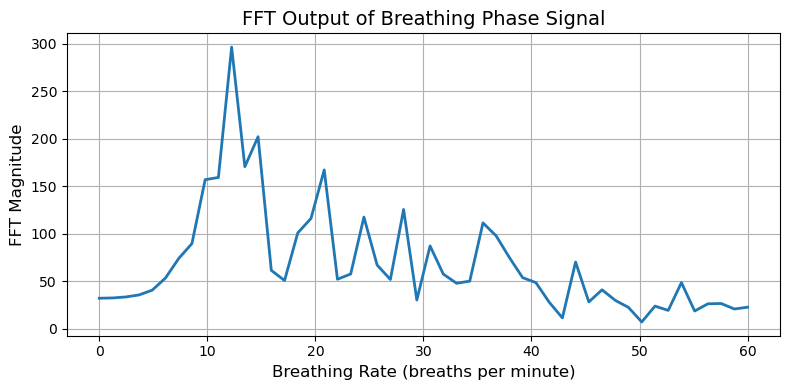

Breathing Rate (initial estimate): 12.24 BPM


In [31]:
### Breathing Rate ###
t_start = 0 
chirps_per_second = int(1 / chirp_length)
samples_in_window = 60 * chirps_per_second
start_idx = int(t_start * chirps_per_second)
end_idx = start_idx + samples_in_window

cutoff_bpm = 10
cutoff_hz = cutoff_bpm / 60
fs = 1 / chirp_length  # samples/sec
phase_filtered = highpass(detrended_phase, cutoff=cutoff_hz, fs=fs) 

phase_window = phase_filtered[start_idx:end_idx]

fft_result = np.fft.fft(phase_window)
fft_magnitude = np.abs(fft_result)
fft_freqs = np.fft.fftfreq(len(phase_window), d=chirp_length)

# select frequencies within 0-1 Hz (~0-60 BPM)
positive_freqs = fft_freqs[:len(fft_freqs)//2]
positive_mags = fft_magnitude[:len(fft_magnitude)//2]
bpm_freqs = positive_freqs * 60
mask = (bpm_freqs >= 0) & (bpm_freqs <= 60)
bpm_freqs = bpm_freqs[mask]
positive_mags = positive_mags[mask]

peak_index = np.argmax(positive_mags)
peak_bpm = bpm_freqs[peak_index]
peak_mag = positive_mags[peak_index]

plt.figure(figsize=(8, 4))
plt.plot(bpm_freqs, positive_mags, linewidth=2)
plt.xlabel("Breathing Rate (breaths per minute)", fontsize=12)
plt.ylabel("FFT Magnitude", fontsize=12)
plt.title("FFT Output of Breathing Phase Signal", fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Breathing Rate (initial estimate): {peak_bpm:.2f} BPM")